In [45]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter
from scipy.fftpack import fft
%matplotlib inline

In [46]:
#read csv file and return its data-frame
def read_csv_file(acc, gyro, mode):
    df_gyro = pd.read_csv(gyro, index_col=False)
    df      = pd.read_csv(acc,  index_col=False)
    df.rename(columns = {'X': 'AX', 'Y':'AY', 'Z':'AZ'}, inplace = True)
    df['GX'] = df_gyro['X']
    df['GY'] = df_gyro['Y']
    df['GZ'] = df_gyro['Z']
    
    df['activity'] = mode
    
    return df



In [47]:
#data for bike
acc_file = 'data/Bike2308/2018-08-23_16-18-07/AccelerometerLinear.csv'
gyro_file= 'data/Bike2308/2018-08-23_16-18-07/Gyroscope.csv'

df_bike = read_csv_file(acc_file, gyro_file, 'bike')
df_bike.reset_index(drop = True, inplace = True)
print("shape -", df_bike.shape)
df_bike = df_bike[3000:13000]
df_bike.reset_index(drop = True, inplace = True)
print("shape -", df_bike.shape)
df_bike.head()

shape - (14413, 8)
shape - (10000, 8)


,Milliseconds,AX,AY,AZ,GX,GY,GZ,activity
0,60002,0.946191,0.335965,-1.380772,-0.063095,-0.078720,0.035873,bike
1,60021,0.282677,0.677211,-0.592512,-0.114227,-0.141571,0.008179,bike
2,60041,0.541477,0.866996,1.060262,-0.052444,-0.141571,-0.037628,bike
3,60061,0.069439,0.456029,0.068076,0.149963,0.006500,-0.031235,bike
4,60082,0.005020,-0.462948,-1.091515,0.076462,-0.005219,-0.020584,bike


In [48]:
#data for car

acc_file = 'data/car/2018-08-17_16-43-04/AccelerometerLinear.csv'
gyro_file= 'data/car/2018-08-17_16-43-04/Gyroscope.csv'

df_car = read_csv_file(acc_file, gyro_file, 'car')

print("shape -", df_car.shape)
df_car = df_car[1300:12000]
df_car.reset_index(drop = True, inplace = True)
print("shape -", df_car.shape)
df_car.head()

shape - (6646, 8)
shape - (5346, 8)


,Milliseconds,AX,AY,AZ,GX,GY,GZ,activity
0,26000,1.310577,-0.599656,-2.653413,-0.030792,-0.118576,-0.002655,car
1,26020,0.001736,-1.469157,2.047003,-0.094711,0.188217,0.012268,car
2,26041,-0.361463,-0.839294,0.419466,0.088516,0.030563,0.010132,car
3,26061,1.720914,-0.621697,0.038787,-0.090454,-0.015244,-0.003723,car
4,26080,2.569507,-1.287929,-0.327906,-0.049973,-0.208054,-0.003723,car


Text(0,0.5,'Amplitude ($rad/s$)')

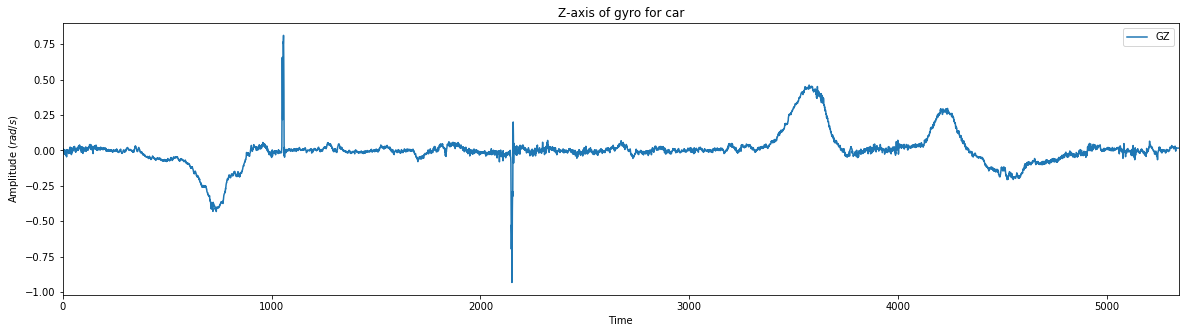

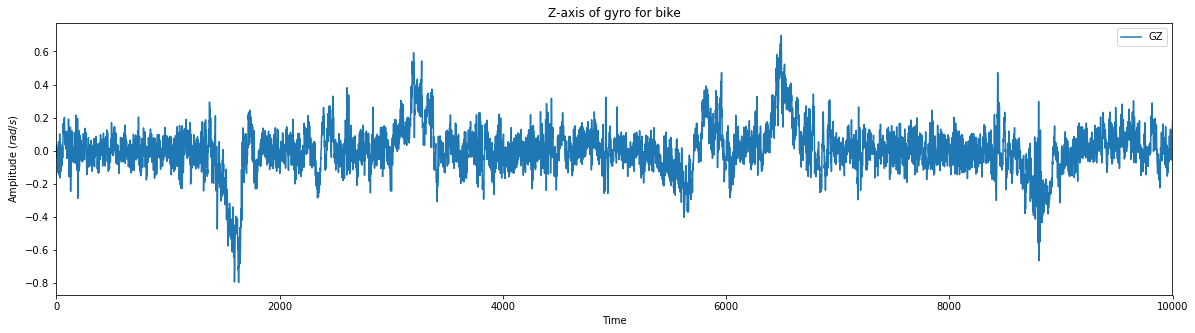

In [49]:
df_car[['GZ']].plot(figsize =(20,5), title = 'Z-axis of gyro for car')
plt.xlabel('Time')
plt.ylabel('Amplitude ($rad/s$)')

df_bike[['GZ']].plot(figsize =(20,5), title = 'Z-axis of gyro for bike')
plt.xlabel('Time')
plt.ylabel('Amplitude ($rad/s$)')

In [50]:
def GaussianFilter(df, window_length):
    df1 = df
    df1['AX'] = gaussian_filter(df['AX'], window_length)
    df1['AY'] = gaussian_filter(df['AY'], window_length)
    df1['AZ'] = gaussian_filter(df['AZ'], window_length)

    df1['GX'] = gaussian_filter(df['GX'], window_length)
    df1['GY'] = gaussian_filter(df['GY'], window_length)
    df1['GZ'] = gaussian_filter(df['GZ'], window_length)
    
    return df1


Text(0,0.5,'Amplitude ($rad/s$)')

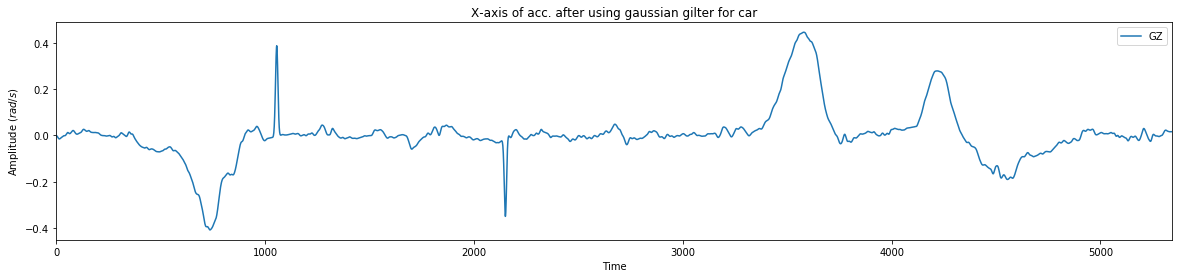

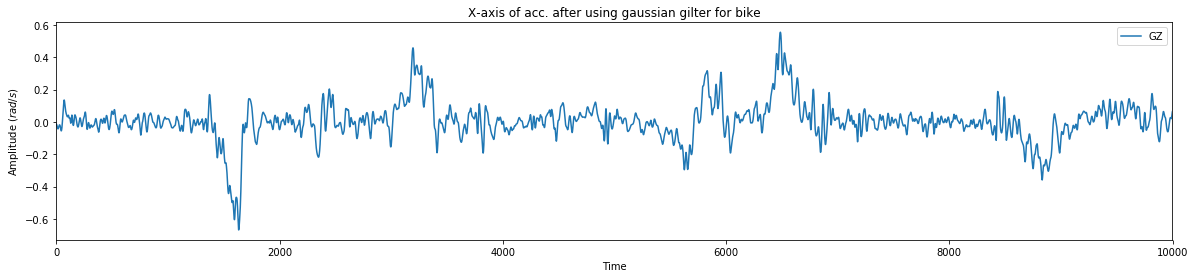

In [51]:
df_car_smooth = GaussianFilter(df_car, 5)
df_car_smooth[['GZ']].plot(figsize = (20,4), title = "X-axis of acc. after using gaussian gilter for car")
plt.xlabel('Time')
plt.ylabel('Amplitude ($rad/s$)')

df_bike_smooth = GaussianFilter(df_bike, 5)
df_bike_smooth[['GZ']].plot(figsize = (20,4), title = "X-axis of acc. after using gaussian gilter for bike")
plt.xlabel('Time')
plt.ylabel('Amplitude ($rad/s$)')


In [52]:
#generate frequency domain data from time domain data usinf Fast Fourier transformation
def FFT(df, features):
    fftfeatures = []
    
    for i in features:
        reals = np.real(np.fft.rfft(df[i]))
        imagn = np.imag(np.fft.rfft(df[i]))

        complexs = [reals[0]]
        n = len(reals)
        if(n%2 == 0):
            complexs.append(imagn[0])
        for j in range(1, n-1):
            complexs.append(reals[j])
            complexs.append(imagn[j])
#         complexs.append(reals[j])
        if( len(df) > len(complexs)):
            complexs.append(imagn[j])
        df['f'+i] = complexs
        fftfeatures.append('f'+i)
    return df

In [53]:
features = ['AX', 'AY', 'AZ', 'GX', 'GY', 'GZ']
df_freq_car = FFT(df_car, features)
df_freq_bike = FFT(df_bike, features)
df_freq_bike

,Milliseconds,AX,AY,AZ,GX,GY,GZ,activity,fAX,fAY,fAZ,fGX,fGY,fGZ
0,60002,0.389429,0.270027,-0.179242,-0.004421,-0.066611,-0.014123,bike,-619.431623,-1116.646935,5.439335e+01,-58.661314,46.307175,42.153945
1,60021,0.383271,0.258645,-0.167288,-0.003469,-0.065612,-0.014847,bike,-37.506253,13.900211,3.989683e+01,-2.320356,-18.027805,-143.331798
2,60041,0.371673,0.237095,-0.144573,-0.001742,-0.063729,-0.016242,bike,68.355926,20.390148,-1.642658e+01,2.068265,-0.238203,42.262493
3,60061,0.356164,0.207692,-0.113133,0.000447,-0.061182,-0.018218,bike,155.575573,253.675925,-4.904057e+01,10.026813,-9.467926,-24.100016
4,60082,0.338680,0.173478,-0.075654,0.002709,-0.058244,-0.020660,bike,223.624462,108.406066,2.283450e+01,16.566184,-12.123437,-13.090061
5,60101,0.321430,0.137947,-0.034949,0.004668,-0.055187,-0.023438,bike,-67.375648,-27.901673,-1.192756e+01,12.773124,33.781671,308.090755
6,60121,0.306561,0.104570,0.006283,0.006045,-0.052221,-0.026421,bike,-619.667283,178.383632,-8.620790e+01,-7.441227,28.309982,25.618516
7,60142,0.295824,0.076417,0.045714,0.006703,-0.049469,-0.029480,bike,217.320390,343.456747,1.709021e+00,31.139227,-16.669449,44.985499
8,60161,0.290413,0.055776,0.081315,0.006645,-0.046958,-0.032488,bike,-420.196039,-202.814493,2.426067e+01,-3.323027,3.722492,-39.888253
9,60181,0.290700,0.043943,0.111431,0.006007,-0.044629,-0.035317,bike,-79.872506,196.722479,-4.292253e+01,3.390348,2.491321,-8.662919


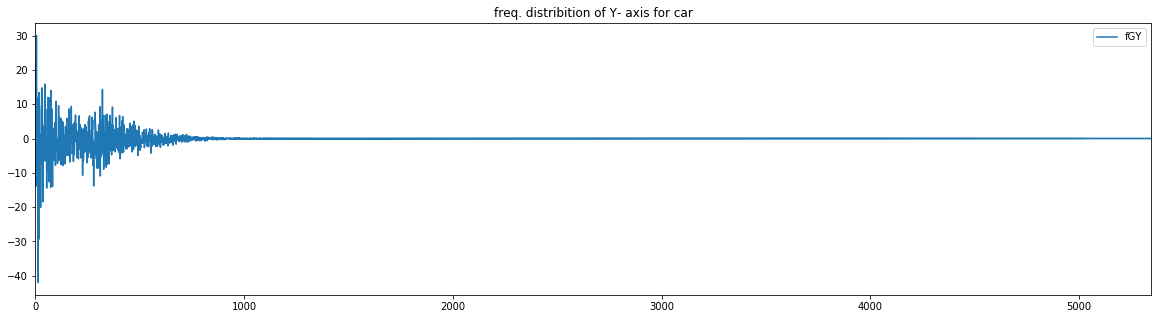

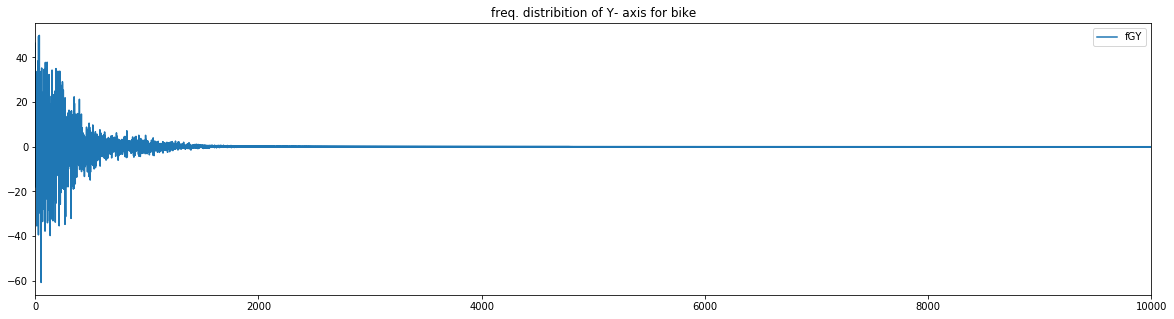

In [54]:
df_freq_car[['fGY']].plot(figsize =(20,5), title = "freq. distribition of Y- axis for car")
df_freq_bike[['fGY']].plot(figsize =(20,5), title = "freq. distribition of Y- axis for bike")

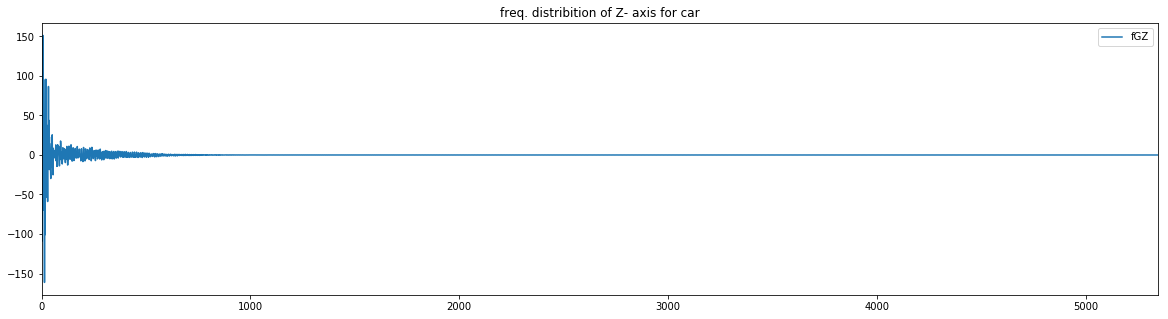

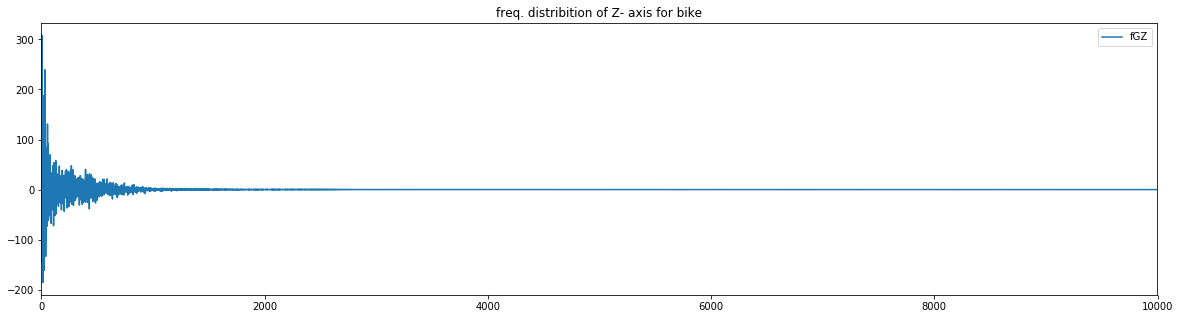

In [55]:
df_freq_car[['fGZ']].plot(figsize =(20,5), title = "freq. distribition of Z- axis for car")
df_freq_bike[['fGZ']].plot(figsize =(20,5), title = "freq. distribition of Z- axis for bike")

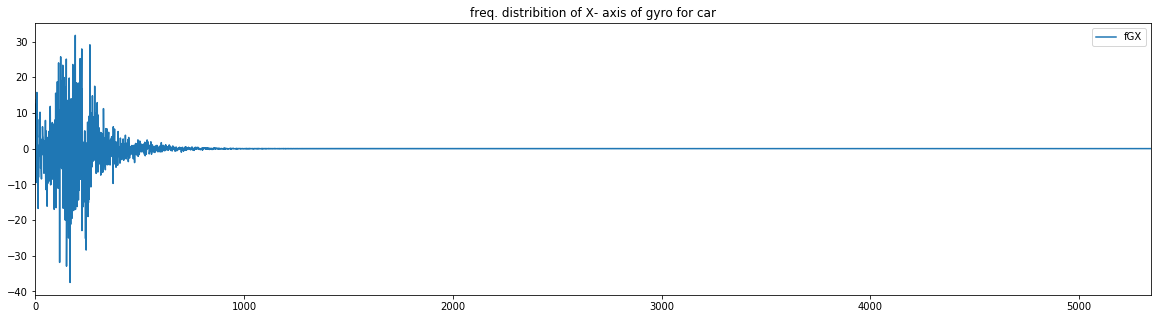

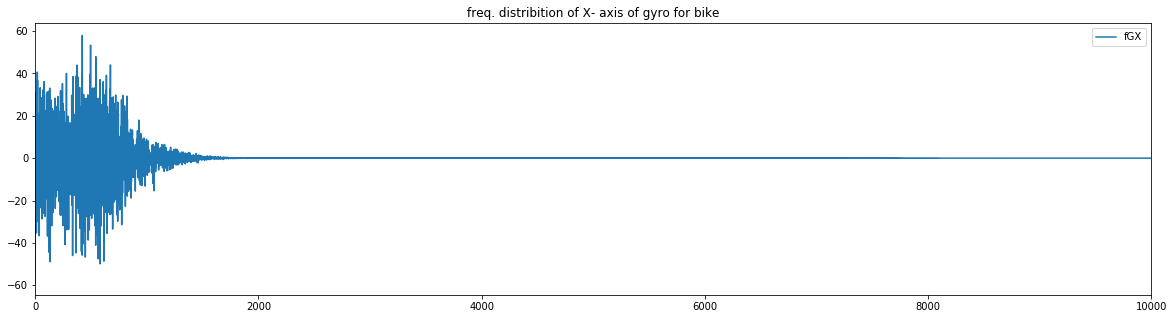

In [56]:
df_freq_car[['fGX']].plot(figsize =(20,5), title = "freq. distribition of X- axis of gyro for car")
df_freq_bike[['fGX']].plot(figsize =(20,5), title = "freq. distribition of X- axis of gyro for bike")

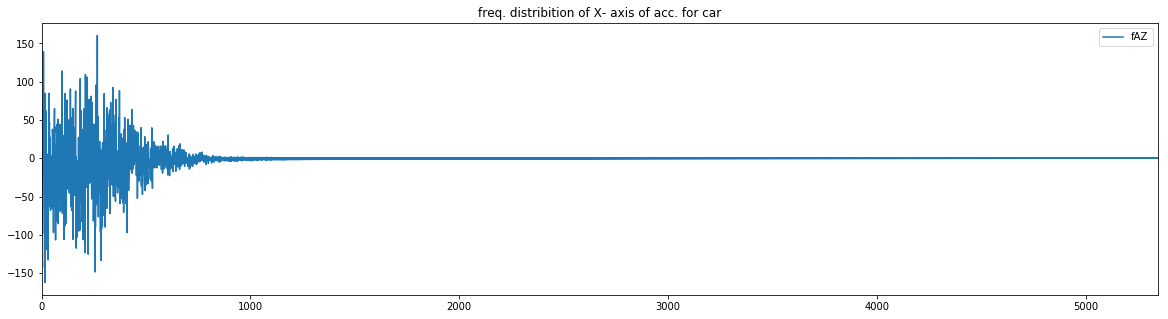

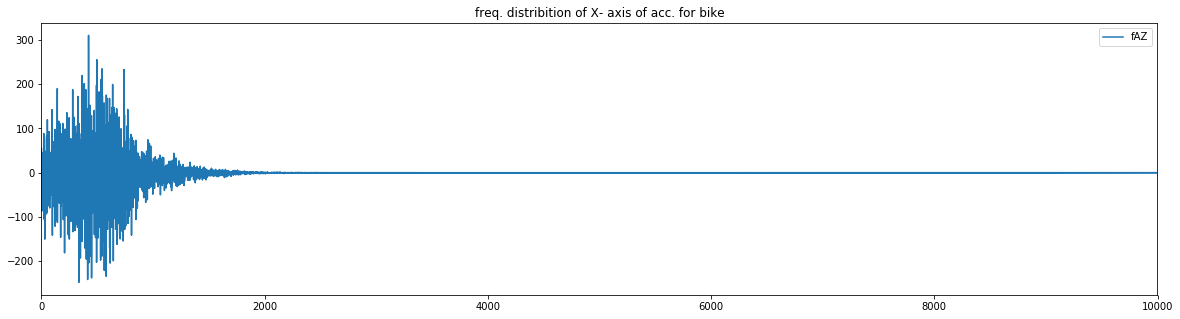

In [57]:
df_freq_car[['fAZ']].plot(figsize =(20,5), title = "freq. distribition of X- axis of acc. for car")
df_freq_bike[['fAZ']].plot(figsize =(20,5), title = "freq. distribition of X- axis of acc. for bike")

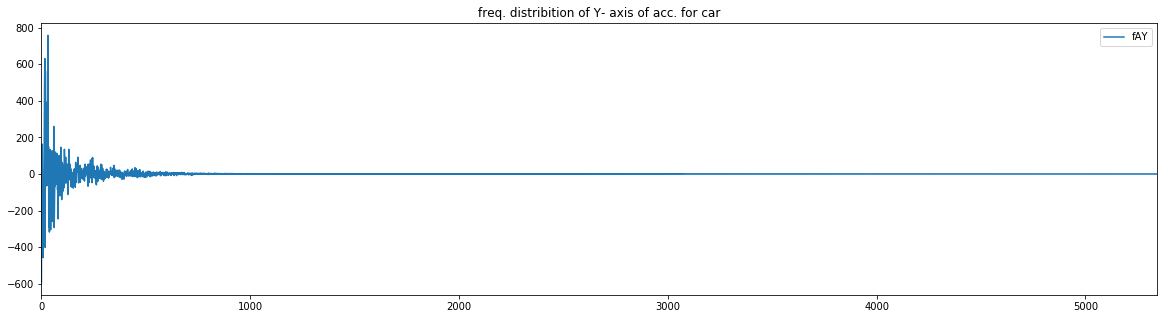

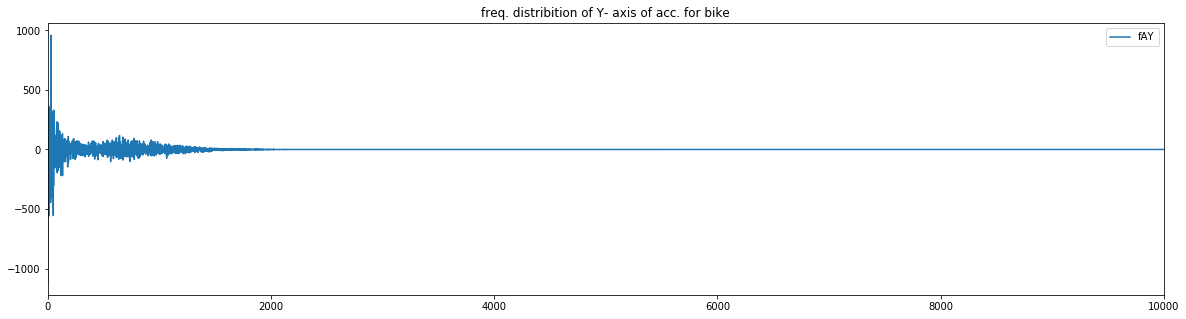

In [58]:
df_freq_car[['fAY']].plot(figsize =(20,5), title = "freq. distribition of Y- axis of acc. for car")
df_freq_bike[['fAY']].plot(figsize =(20,5), title = "freq. distribition of Y- axis of acc. for bike")

Text(0,0.5,'Amplitude ($db$)')

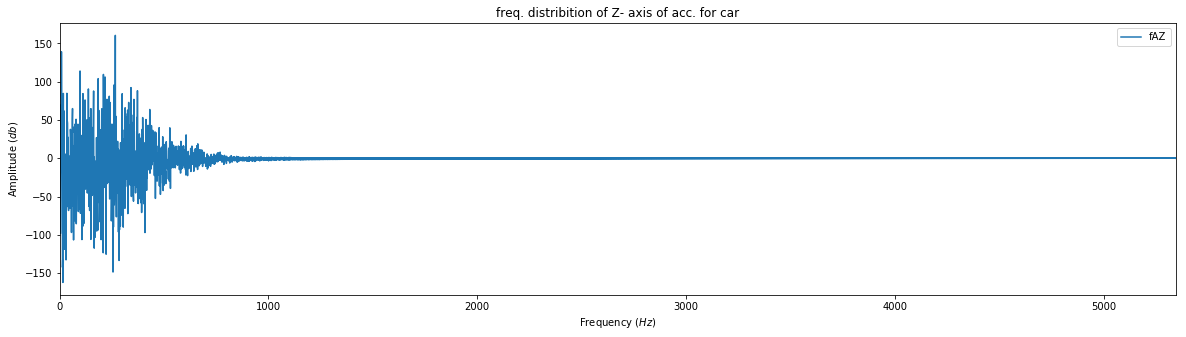

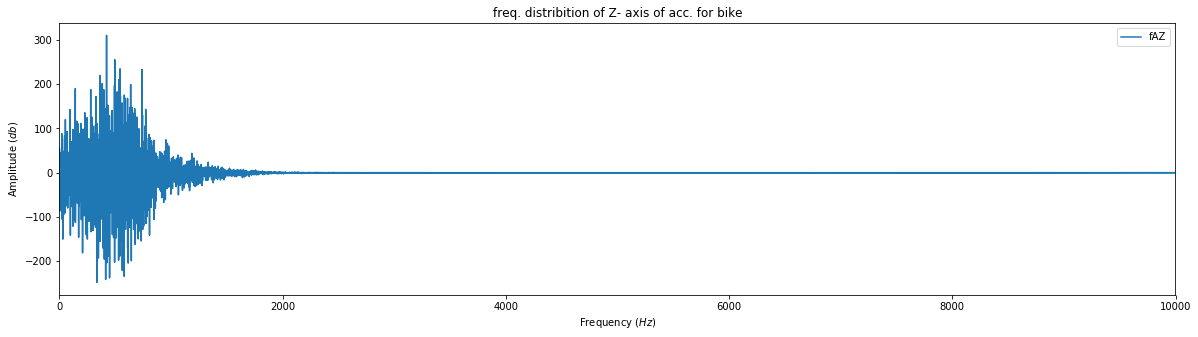

In [59]:
df_freq_car[['fAZ']].plot(figsize =(20,5), title = "freq. distribition of Z- axis of acc. for car")
plt.xlabel('Frequency ($Hz$)')
plt.ylabel('Amplitude ($db$)')

df_freq_bike[['fAZ']].plot(figsize =(20,5), title = "freq. distribition of Z- axis of acc. for bike")
plt.xlabel('Frequency ($Hz$)')
plt.ylabel('Amplitude ($db$)')